# Introduction

# Necessary imports

In [75]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Import the data

Now we load in a dataset from the [**IBM Base Samples**](https://www.ibm.com/docs/en/cognos-analytics/11.1.0?topic=samples-base). Specifically, we are going to use the [**Telco Churn Dataset**](https://github.com/TrungKhoaLe/ds-ml-dl-collection/blob/main/dataset/telco_customer_churn.csv). This dataset will allow us to predict if someone will stop using Telco's services or not using a variety of continuous and categorical features.

In [35]:
df = pd.read_csv("https://raw.githubusercontent.com/TrungKhoaLe/ds-ml-dl-collection/main/dataset/telco_customer_churn.csv")

Let's glance the first five samples of the dataset by using the ```head()``` function of the Pandas dataframe.

In [36]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


The last four columns are sort of exit interview information that is collected from people that left Telco. 

We do not want to use this information in the prediction because someone is not going to do the exit interview before they leave the company.

These features give us perfect predictive signals, so we are going to remove them from the dataset.

In [37]:
df.drop(["Churn Label", "Churn Score", "CLTV", "Churn Reason"],
        axis=1, inplace=True)
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


Some of the other features only contain a single value, and will not be useful for classification. For example: 

In [38]:
df["Count"].unique()

array([1])

In [39]:
df["Country"].unique()

array(['United States'], dtype=object)

In [40]:
df["State"].unique()

array(['California'], dtype=object)

We can omit those features from the analysis because they are not going to help with predictions. In contrast, ```City``` contains a bunch of different city names, so we will leave it in.

In [41]:
df["City"].unique()

array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)

We will also remove ```CustomerID``` because it is different for every customer and useless for classification. Lastly, we will drop ```Lat Long``` because thre are separate columns for ```Latitude``` and ```Longitude```.

In [42]:
df.drop(["CustomerID", "Count", "Country", "State", "Lat Long"],
        axis=1, inplace=True)
df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


**NOTE:** **XGBoost** accepts whitespace in the feature names. However, we cannot have any whitespace if we want to draw a tree. So, let's take care of that now by replacing the white space in the city names with an underscore character ```_```.

In [43]:
df["City"].replace(" ", "_", regex=True, inplace=True)
df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [44]:
df["City"].unique()[0:10]

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', 'Lynwood',
       'Marina_Del_Rey', 'Inglewood', 'Santa_Monica', 'Torrance',
       'Whittier', 'La_Habra'], dtype=object)

We also need to eliminate the whitespace in the column names.

In [45]:
df.columns = df.columns.str.replace(" ", "_")
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


# Identidying missing data

The biggest part of any data analysis project is making sure that the data are correctly formatted and fixing it when it is not.

One thing that is relatively unique about **XGBoost** is that it has default behavior for missing data. So, all we have to do is identify missing values and make sure they are set to ```0```.

First, let's see what sort of data is in each column.

In [46]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

A lot of columns are ```object```, and this is fine, as we saw above when we ran ```head()``` there were a lot of text responses, like ```Yes``` and ```No```. Nevertheless, let's verify that we are getting what we expect. 

In [47]:
df["Phone_Service"].unique()

array(['Yes', 'No'], dtype=object)

In [48]:
df["City"].unique()

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', ..., 'Standish',
       'Tulelake', 'Olympic_Valley'], dtype=object)

In [49]:
df["Zip_Code"].unique()

array([90003, 90005, 90006, ..., 96128, 96134, 96146])

In practice, we should check every other column. For columns that have long lists of values, I nearly always stream the values to text files for further analysis. 

In this particular dataset, all the other columns are fine, except the **Total_Charges** column. **Total_Charges** looks like it contains numbers, not text, but the ```object``` data type suggests that it contains more than just numbers.

In [50]:
df["Total_Charges"].unique()

array(['108.15', '151.65', '820.5', ..., '7362.9', '346.45', '6844.5'],
      dtype=object)

In [51]:
## Check to determine issues in this column
## df["Total_Charges"] = pd.to_numeric(df["Total_Charges"])

There are blank spaces, " ", in the data. We need to deal with those.

# Dealing with missing data, XGBoost style

First, we need to determine how many rows are missing data. If it is a lot, then we might have a problem on our hands that is bigger than what **XGBoost** can deal with on its own. If it is not that many, we can just set them to ```0```.

In [52]:
len(df.loc[df["Total_Charges"] == " "])

11

We only have 11 rows missing values. Let's look at them.

In [53]:
df.loc[df["Total_Charges"] == " "]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


**Tenure_Month** being ```0``` indicates that all 11 people with ```Total_Charges == " "``` have just signed up. We have a few choices here, we can set **Total_Charges** to ```0``` for these 11 people or we can remove them. We proceed with the former option because we just have a handful of people having Total_Charges equal to ```0```.

In [54]:
df.loc[df["Total_Charges"] == " ", "Total_Charges"] = 0

Let's verify the result after modifying **Total_Charges** by looking at customers who had **Tenure_Months** set to ```0```.

In [55]:
df.loc[df["Tenure_Months"] == 0]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


**Total_Charges** still has the object data type. That is no good because **XGBoost** only allows ```int```, ```float```, or ```boolean``` data types. We can fix this by converting it with ```to_numeric()```.

In [56]:
df["Total_Charges"] = pd.to_numeric(df["Total_Charges"])
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

We have dealt with the missing data, we can replace all of the other whitespaces in all of the columns with underscores. Note that we are doing this so that we can draw a picture of the **XGBoost** trees.

In [57]:
df.replace(" ", "_", regex=True, inplace=True)
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


# Split the data into dependent and independent variables

We are going to split the data into two parts:

1. The columns of the data that we will use to make classifications, a.k.a. predictors,
2. the column of the data that we want to predict, a.k.a. response variable.

We are going to use the conventional notation of **```X```** to represent the predictors, and **```y```** to represent the response variable.



In [58]:
X = df.drop("Churn_Value", axis=1).copy()
X.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30


In [59]:
y = df["Churn_Value"].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Churn_Value, dtype: int64

# One-hot encoding

**XGBoost** natively supports continuous data, like **Monthly_Charges** and **Total_Charges**, it does not natively support categorical data, like **Phone_Service**, which contains 2 different categories. We need to convert a column of categorical data into multiple columns of binary values using a technique called **One-hot encoding**.

The reason we don't use continuous data in this case is that the **XGBoost** tree would be more likely to cluster the data samples that have small distances to each other than the data samples that have large distances to each other.

Before we commit to converting columns with **One-hot encoding**, let's see what happens when we convert **Payment_Method** without saving the results.

In [60]:
pd.get_dummies(X, columns=["Payment_Method"]).head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Monthly_Charges,Total_Charges,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,Month-to-month,Yes,53.85,108.15,0,0,0,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,Month-to-month,Yes,70.70,151.65,0,0,1,0
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,Yes,Month-to-month,Yes,99.65,820.50,0,0,1,0
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Month-to-month,Yes,104.80,3046.05,0,0,1,0
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,Month-to-month,Yes,103.70,5036.30,1,0,0,0


After checking each of the columns for the accepted categories, we are ready to proceed to one-hot encode all columns of categorical data.

In [61]:
X_encoded = pd.get_dummies(X, columns=["City",
                                       "Gender",
                                       "Senior_Citizen",
                                       "Partner",
                                       "Dependents",
                                       "Phone_Service",
                                       "Multiple_Lines",
                                       "Internet_Service",
                                       "Online_Security",
                                       "Online_Backup",
                                       "Device_Protection",
                                       "Tech_Support",
                                       "Streaming_TV",
                                       "Streaming_Movies",
                                       "Contract",
                                       "Paperless_Billing",
                                       "Payment_Method"])
X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,...,1,1,0,0,0,1,1,0,0,0


Let's verify if y only contains **1s** and **0s**.

In [62]:
y.unique()

array([1, 0])

# Build a baseline XGBoost model

This dataset is in fact imbalanced. It is proved by the following number:

In [63]:
sum(y) / len(y)

0.2653698707936959

We see that only **27%** of the people in the dataset left the company. Because of this, when we split the data into training and testing, we will split using stratification in order to maintain the same percentage of the people who left the company in both the training set and the testing set.

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, 
                                                    random_state=42,
                                                    stratify=y)

Let's verify if using ```stratify``` worked as expected.

In [65]:
sum(y_train) / len(y_train)

0.2654297614539947

In [66]:
sum(y_test) / len(y_test)

0.26519023282226006

```stratify``` worked as expected and both ```y_train``` and ```y_test``` have the same percentage of people that left the company.

In [77]:
clf_xgb = xgb.XGBClassifier(objective="binary:logistic",
                            eval_metric="aucpr",
                            early_stopping_rounds=10,
                            base_score=0.5,
                            booster="gbtree",
                            colsample_bynode=1,
                            colsample_bytree=1,
                            seed=42)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.64036
[1]	validation_0-aucpr:0.64404
[2]	validation_0-aucpr:0.65124
[3]	validation_0-aucpr:0.65052
[4]	validation_0-aucpr:0.65321
[5]	validation_0-aucpr:0.64854
[6]	validation_0-aucpr:0.65459
[7]	validation_0-aucpr:0.65895
[8]	validation_0-aucpr:0.65746
[9]	validation_0-aucpr:0.65850
[10]	validation_0-aucpr:0.66217
[11]	validation_0-aucpr:0.66527
[12]	validation_0-aucpr:0.66322
[13]	validation_0-aucpr:0.66310
[14]	validation_0-aucpr:0.66000
[15]	validation_0-aucpr:0.66027
[16]	validation_0-aucpr:0.65781
[17]	validation_0-aucpr:0.65593
[18]	validation_0-aucpr:0.65738
[19]	validation_0-aucpr:0.65829
[20]	validation_0-aucpr:0.65683


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

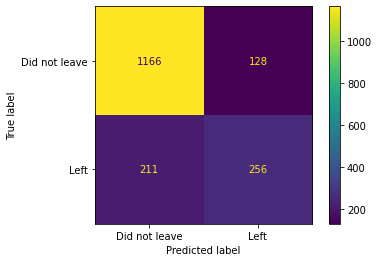

In [78]:
ConfusionMatrixDisplay.from_estimator(clf_xgb,
                                      X_test,
                                      y_test,
                                      values_format="d",
                                      display_labels=["Did not leave", "Left"])

In the confusion matrix, we see that of the **1294** people that **did not leave**, **1166 (90%)** were correctly classified. And of the **467** people that **left the company**, **256 (55%)** were correctly classified. So this **XGBoost** model version was not awsome. Part of the problem is that our data is imbalanced. People leaving costs the company a lot of money, we would like to capture more of the people that left. The good news is XGBoost has a parameter ```scale_pos_weight```that helps with imbalanced data. 

# Optimize parameters using Cross Validation and GridSearch()

In [95]:
# # ROUND 1
# param_grid = {
#     "max_depth": [3, 4, 5],
#     "learn_rate": [0.1, 0.01, 0.05],
#     "gamma": [0, 0.25, 1.0],
#     "reg_lambda": [0, 1.0, 10.0],
#     "scale_pos_weight": [1, 3, 5]
# }

# ROUND 2
# param_grid = {
#     "max_depth": [5],
#     "learning_rate": [0.05, 0.75, 1],
#     "gamma": [1.0],
#     "reg_lambda": [10, 20, 100],
#     "scale_pos_weight": [1]
# }

# optimal_params = GridSearchCV(
#     estimator=xgb.XGBClassifier(objective="binary:logistic",
#                                 seed=42,
#                                 subsample=0.9,
#                                 colsample_bytree=0.5,
#                                 early_stopping_rounds=10,
#                                 eval_metric="aucpr"),
#     param_grid=param_grid,
#     scoring="roc_auc",
#     verbose=2,
#     n_jobs=10,
#     cv=3
# )

# optimal_params.fit(X_train,
#                    y_train,
#                    eval_set=[(X_test, y_test)],
#                    verbose=False)
# print(optimal_params.best_params_)

# Building, evaluating, drawing and interpreting the optimized XGBoost model

Now that we have the ideal parameter values, we can build the final **XGBoost** model.

In [93]:
clf_xgb = xgb.XGBClassifier(seed=42,
                            objective="binary:logistic",
                            gamma=1.0,
                            learning_rate=0.05,
                            max_depth=5,
                            reg_lambda=10,
                            scale_pos_weight=3,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            early_stopping_rounds=10,
                            eval_metric="aucpr")
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.51397
[1]	validation_0-aucpr:0.55169
[2]	validation_0-aucpr:0.60780
[3]	validation_0-aucpr:0.62136
[4]	validation_0-aucpr:0.62610
[5]	validation_0-aucpr:0.62063
[6]	validation_0-aucpr:0.62972
[7]	validation_0-aucpr:0.62828
[8]	validation_0-aucpr:0.63184
[9]	validation_0-aucpr:0.63297
[10]	validation_0-aucpr:0.63577
[11]	validation_0-aucpr:0.63805
[12]	validation_0-aucpr:0.63858
[13]	validation_0-aucpr:0.63562
[14]	validation_0-aucpr:0.63606
[15]	validation_0-aucpr:0.63686
[16]	validation_0-aucpr:0.63681
[17]	validation_0-aucpr:0.63725
[18]	validation_0-aucpr:0.63815
[19]	validation_0-aucpr:0.64025
[20]	validation_0-aucpr:0.64044
[21]	validation_0-aucpr:0.64067
[22]	validation_0-aucpr:0.64768
[23]	validation_0-aucpr:0.64911
[24]	validation_0-aucpr:0.65410
[25]	validation_0-aucpr:0.65373
[26]	validation_0-aucpr:0.65396
[27]	validation_0-aucpr:0.65297
[28]	validation_0-aucpr:0.65472
[29]	validation_0-aucpr:0.65345
[30]	validation_0-aucpr:0.65395
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=1.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

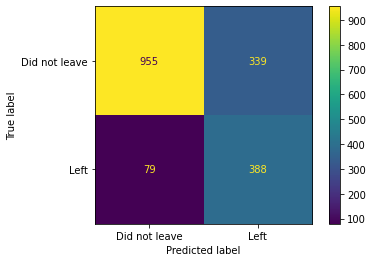

In [94]:
ConfusionMatrixDisplay.from_estimator(clf_xgb,
                                      X_test,
                                      y_test,
                                      values_format="d",
                                      display_labels=["Did not leave", "Left"])

We see that the optimized XGBoost model is a lot better at identifying people that left the company. Of the **467** people that left the company, **388 (83%)** were correctly classified. However, this improvement was at the expense of not being able to correctly classify as many people that did not leave. That said, this trade off may be better for the company because now it can focus resources on the people that leave it that will help them retain them.

weight: {'Zip_Code': 1.0, 'Latitude': 1.0, 'Longitude': 2.0, 'Total_Charges': 9.0, 'City_Olivehurst': 1.0, 'Senior_Citizen_No': 1.0, 'Partner_No': 1.0, 'Phone_Service_No': 2.0, 'Internet_Service_No': 1.0, 'Online_Security_No': 1.0, 'Online_Backup_No': 1.0, 'Device_Protection_No': 1.0, 'Tech_Support_Yes': 3.0, 'Streaming_TV_No': 2.0, 'Payment_Method_Credit_card_(automatic)': 1.0, 'Payment_Method_Mailed_check': 2.0}
gain: {'Zip_Code': 10.309720039367676, 'Latitude': 4.738397598266602, 'Longitude': 7.948467254638672, 'Total_Charges': 54.91706848144531, 'City_Olivehurst': 5.74346923828125, 'Senior_Citizen_No': 20.408409118652344, 'Partner_No': 12.574092864990234, 'Phone_Service_No': 8.900158882141113, 'Internet_Service_No': 30.421142578125, 'Online_Security_No': 1189.2420654296875, 'Online_Backup_No': 105.1788330078125, 'Device_Protection_No': 8.229458808898926, 'Tech_Support_Yes': 42.18313217163086, 'Streaming_TV_No': 12.615936279296875, 'Payment_Method_Credit_card_(automatic)': 15.344299

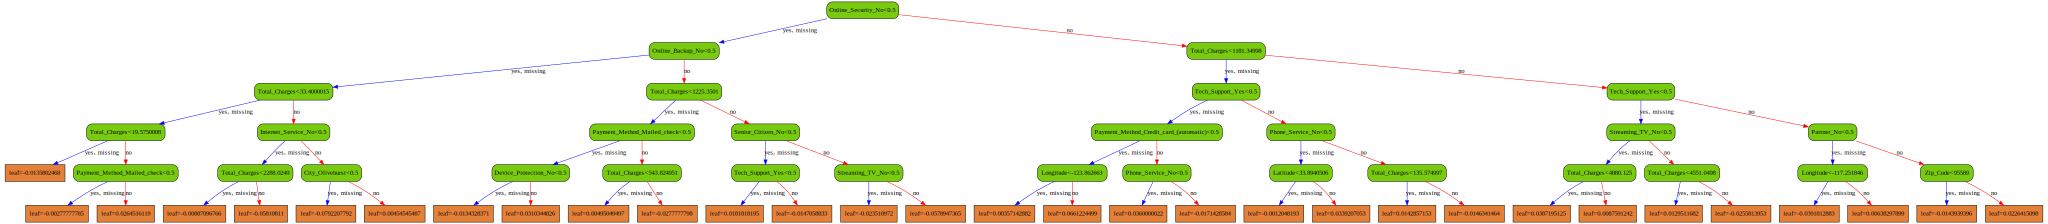

In [97]:
clf_xgb = xgb.XGBClassifier(seed=42,
                            objective="binary:logistic",
                            gamma=1.0,
                            learning_rate=0.05,
                            max_depth=5,
                            reg_lambda=10,
                            scale_pos_weight=3,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            eval_metric="aucpr",
                            n_estimators=1)
clf_xgb.fit(X_train,
            y_train)

bst = clf_xgb.get_booster()
for importance_type in ("weight", "gain", "cover", "total_gain", "total_cover"):
    print(f"{importance_type}: {bst.get_score(importance_type=importance_type)}")

node_params = {"shape": "box",
               "style": "filled, rounded",
               "fillcolor": "#78cbe"}

leaf_params = {"shape": "box",
               "style": "filled",
               "fillcolor": "#e48038"}


xgb.to_graphviz(clf_xgb, num_trees=0, size="10, 10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)